In [1]:
import cv2
import dlib
import numpy as np
import pandas as pd 
from scipy.spatial import distance
from PIL import Image
import os
from google.colab.patches import cv2_imshow

Makeup Sections:
- Eyebrows
- Eyelids
- Lash line
- Nose
- Lips



Reference of the different annotations:


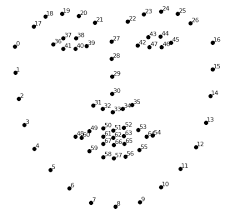

In [2]:
# download the necessary models
# face detector
!wget https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
# landmark detector
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2022-01-30 03:01:42--  https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal     [  <=>               ]   9.34M  36.3MB/s    in 0.3s    

2022-01-30 03:01:44 (36.3 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [9796825]

--2022-01-30 03:01:44--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  51.3MB/s    in 1.2s    

2022-01-30 03:01:45 (51.3 MB/s) - ‘shape_predict

<!--  -->

In [3]:
classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

The landmarks function predicts the landmarks on the given image. The function patches determines the patches for the relevant makeup sections.

In [67]:
def get_landmarks(img):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector(gray)


  for face in faces:
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()

  annotations = []

  if len(faces) == 0:
    # face is in an unorthodox position
    # landmarks are not detected
    print("face not detected!")
    return None 

  landmarks = predictor(gray, face)
  annotations.append([(landmarks.part(n).x, landmarks.part(n).y) for n in range(0,68)])
  return annotations

def patches(annotations):
  # this function just populates this arrays in
  # preparation for the plot function
  right_eyebrow = []
  for i in range(17,22):
    x = annotations[0][i][0]
    y = annotations[0][i][1]
    right_eyebrow.append((x,y))

  left_eyebrow = []
  for i in range(22,27):
    left_eyebrow_x = annotations[0][i][0]
    left_eyebrow_y = annotations[0][i][1]
    left_eyebrow.append((left_eyebrow_x, left_eyebrow_y))

  right_lash = []
  for i in range(36,40):
    right_lash_x = annotations[0][i][0]
    right_lash_y = annotations[0][i][1]
    right_lash.append((right_lash_x, right_lash_y))

  left_lash = []
  for i in range(42,46):
    left_lash_x = annotations[0][i][0]
    left_lash_y = annotations[0][i][1]
    left_lash.append((left_lash_x, left_lash_y))

  right_eyelid = []
  for i in range(17,22):
    x = annotations[0][i][0]
    y = annotations[0][i][1]
    right_eyelid.append((x,y))
  for i in range(36,40):
    x = annotations[0][i][0]
    y = annotations[0][i][1]
    right_eyelid.append((x,y))

  left_eyelid = []
  for i in range(23,27):
    x = annotations[0][i][0]
    y = annotations[0][i][1]
    left_eyelid.append((x,y))
  for i in range(42,46):
    x = annotations[0][i][0]
    y = annotations[0][i][1]
    left_eyelid.append((x,y))

  nose = []
  for i in range(27,31):
    x = annotations[0][i][0]
    y = annotations[0][i][1]
    nose.append((x,y))

  outer_lip = []
  for i in range(49,61):
    x = annotations[0][i][0]
    y = annotations[0][i][1]
    outer_lip.append((x,y))

  inner_lip = []
  for i in range(60,68):
    x = annotations[0][i][0]
    y = annotations[0][i][1]
    inner_lip.append((x,y))

  # return the arrays in the following order
  # right_eyebrow, left_eyebrow, right_lash, left_lash, 
  # right_eyelid, left_eyelid, nose, outer_lip, inner_lip
  return (right_eyebrow, left_eyebrow, right_lash, left_lash, right_eyelid, left_eyelid, nose, outer_lip, inner_lip


The highlight function just plots dots on the specified points

In [5]:
# Arguments:
# points_arr : this is the set of arrays returned from patches()
# img : this is the image we are editing
# part : this is a string that the user inputs to specify the part of interest
def highlight(points_arr,img,part):
  # match the string with the correct array
  parts =  {"right_eyebrow":points_arr[0], 
            "left_eyebrow":points_arr[1], 
            "right_lash" : points_arr[2],
            "left_lash" : points_arr[3],
            "right_eyelid" : points_arr[4],
            "left_eyelid" : points_arr[5],
            "nose" : points_arr[6],
            "outer_lip" : points_arr[7],
            "inner_lip": points_arr[8]}
  part_of_interest = parts[part]
  for coord in part_of_interest:
    img = cv2.circle(img,coord, radius=3, color=(0, 0, 255), thickness=-1)

  return img

In [ ]:
# test it out on single image
image = cv2.imread("IMG.jpg")
cv2_imshow(image)

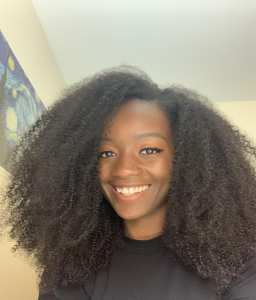

In [12]:
# resize the image
width = 256
height = 300
dim = (width, height)

# resize image
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(resized)

In [13]:
anns = get_landmarks(resized)
parts_arr = patches(anns)
output = highlight(parts_arr,resized,"outer_lip")

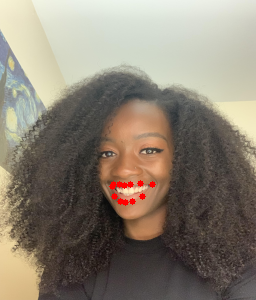

In [14]:
cv2_imshow(output)

Because you cannot run a webcam on Colab I exclude that portion of the code. In this notebook you'll be able to plot points on the landmarks of your choosing on the image of your choice. Hope you had fun with this one! 😊 

Running this algorithm on a video

In [15]:
# define the color

# I made this file after watching this video
# https://www.youtube.com/watch?v=yKZ_A0XzXMU

def length_of_video(video_path):
  # smaller helper function
  cap = cv2.VideoCapture(video_path)
  length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  return length

def extracting_frames(video_path, save_path,skip_frames):
  # extract frames and save them as jpg
  # video_path: path to video
  # save_path : save_directory for extracted images
  # skip_frames: save every "X" frames

  print("Extracting Frames")

  # Windows OS format
  # C;\temp\video.mp4 = C:\temp,video.mp4
  _, file_name = os.path.split(video_path)

  # tabby.mp4 = [tabby,.mp4]
  file_name_without_ext = os.path.splitext(file_name)[0]

  # check length
  length = length_of_video(video_path)
  if length == 0:
    print('Length is 0, exiting extracting phase')
    return 0

  cap = cv2.VideoCapture(video_path)
  count = 0 #keep count of frames
  added_string = "img" #DLC format


  # test first frame
  ret, frame= cap.read() #ret frame returned correctly
  test_file_path = os.path.join(
      save_path,
      file_name_without_ext[:] +\
      '{}{}.jpg'.format(added_string,count)
  )

  cv2.imwrite(test_file_path,frame)
  if os.path.isfile(test_file_path):
    print("Saving Test Frame Successfully" + " continuing Extraction Phase")

    count = 0
    while ret:
      ret,frame = cap.read()
      if ret and (count % skip_frames) == 0:
        cv2.imwrite(os.path.join(
            save_path,
            file_name_without_ext[:]+
            '{}{}.jpg'.format(added_string,count)),frame)
        count +=1
        print(count)
      else:
        count += 1
  else:
    print("Problem with Saving Test fRAME CV2 encoding, cannot save file")
    return 0

  cap.release()
  print("**********FINISHED EXTRACTION*************")


In [42]:
!mkdir face_frames

In [ ]:
video = "face.mp4"
save_path = 'face_frames/'
extracting_frames(video,save_path,skip_frames=1)

In [79]:
# Arguments:
# points_arr : this is the set of arrays returned from patches()
# img : this is the image we are editing
# part : this is a string that the user inputs to specify the part of interest
def highlight_all(points_arr,img):
  # match the string with the correct array
  parts =  {"right_eyebrow":points_arr[0], 
            "left_eyebrow":points_arr[1], 
            "right_lash" : points_arr[2],
            "left_lash" : points_arr[3],
            "right_eyelid" : points_arr[4],
            "left_eyelid" : points_arr[5],
            "nose" : points_arr[6],
            "outer_lip" : points_arr[7],
            "inner_lip": points_arr[8]}

  num_parts = len(parts)

  colors = [(153, 204, 255),
            (0,0,255),
            (255, 0, 255),
            (255,153,153),
            (255,255,0),
            (51,255,255),
            (128,255,0),
            (255, 128,0),
            (0,200,50),
            (0,204,204)]

  part_names =  ["right_eyebrow", 
            "left_eyebrow", 
            "right_lash",
            "left_lash",
            "right_eyelid",
            "left_eyelid" ,
            "nose",
            "outer_lip",
            "inner_lip"]

  for coord in range(0,num_parts):
    # print("coord",coord)
    part_of_interest = parts[part_names[coord]]
    # print(part_of_interest)
    # print("here")
    for pos in part_of_interest:
      img = cv2.circle(img, pos, radius=3, color = colors[coord], thickness=-1)

  return img

In [73]:
# create a video from the frames

# The first frames are the original video frames
# The naming is weird so I'll use this code
frame_names = os.listdir('face_frames/')


Run the code on the images and create a video

In [74]:
from os.path import isfile, join
pathIn= 'face_frames/'
pathOut = 'my_face.mp4'

# I'll use 10 to make the video run faster
fps = 60
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
files.sort()
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: int(x[7:-4]))
print(files)

['faceimg0.jpg', 'faceimg1.jpg', 'faceimg2.jpg', 'faceimg3.jpg', 'faceimg4.jpg', 'faceimg5.jpg', 'faceimg6.jpg', 'faceimg7.jpg', 'faceimg8.jpg', 'faceimg9.jpg', 'faceimg10.jpg', 'faceimg11.jpg', 'faceimg12.jpg', 'faceimg13.jpg', 'faceimg14.jpg', 'faceimg15.jpg', 'faceimg16.jpg', 'faceimg17.jpg', 'faceimg18.jpg', 'faceimg19.jpg', 'faceimg20.jpg', 'faceimg21.jpg', 'faceimg22.jpg', 'faceimg23.jpg', 'faceimg24.jpg', 'faceimg25.jpg', 'faceimg26.jpg', 'faceimg27.jpg', 'faceimg28.jpg', 'faceimg29.jpg', 'faceimg30.jpg', 'faceimg31.jpg', 'faceimg32.jpg', 'faceimg33.jpg', 'faceimg34.jpg', 'faceimg35.jpg', 'faceimg36.jpg', 'faceimg37.jpg', 'faceimg38.jpg', 'faceimg39.jpg', 'faceimg40.jpg', 'faceimg41.jpg', 'faceimg42.jpg', 'faceimg43.jpg', 'faceimg44.jpg', 'faceimg45.jpg', 'faceimg46.jpg', 'faceimg47.jpg', 'faceimg48.jpg', 'faceimg49.jpg', 'faceimg50.jpg', 'faceimg51.jpg', 'faceimg52.jpg', 'faceimg53.jpg', 'faceimg54.jpg', 'faceimg55.jpg', 'faceimg56.jpg', 'faceimg57.jpg', 'faceimg58.jpg', 'facei

In [ ]:
# for all the images in the array, 
# resize them and then run the dlib model on them
# resize the image
width = 540
height = 1080
dim = (width, height)

for ig in range(0,len(files)):
  run_img = cv2.imread("face_frames/"+files[ig])
  resized = cv2.resize(run_img, dim, interpolation = cv2.INTER_AREA)
  final = cv2.resize(run_img, dim, interpolation = cv2.INTER_AREA)

  anns = get_landmarks(resized)
  im_h = resized
  if anns is None:
    print("in here")
    im_h = cv2.hconcat([final, resized])
  else:
    parts_arr = patches(anns)
    output = highlight_all(parts_arr,resized)
    im_h = cv2.hconcat([resized, final])

  cv2.imwrite("output/"+files[ig],im_h)

In [87]:
from os.path import isfile, join
pathIn= 'output/'
pathOut = 'my_face.mp4'

# I'll use 10 to make the video run faster
fps = 60
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
files.sort()
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: int(x[7:-4]))
print(files)

['faceimg0.jpg', 'faceimg1.jpg', 'faceimg2.jpg', 'faceimg3.jpg', 'faceimg4.jpg', 'faceimg5.jpg', 'faceimg6.jpg', 'faceimg7.jpg', 'faceimg8.jpg', 'faceimg9.jpg', 'faceimg10.jpg', 'faceimg11.jpg', 'faceimg12.jpg', 'faceimg13.jpg', 'faceimg14.jpg', 'faceimg15.jpg', 'faceimg16.jpg', 'faceimg17.jpg', 'faceimg18.jpg', 'faceimg19.jpg', 'faceimg20.jpg', 'faceimg21.jpg', 'faceimg22.jpg', 'faceimg23.jpg', 'faceimg24.jpg', 'faceimg25.jpg', 'faceimg26.jpg', 'faceimg27.jpg', 'faceimg28.jpg', 'faceimg29.jpg', 'faceimg30.jpg', 'faceimg31.jpg', 'faceimg32.jpg', 'faceimg33.jpg', 'faceimg34.jpg', 'faceimg35.jpg', 'faceimg36.jpg', 'faceimg37.jpg', 'faceimg38.jpg', 'faceimg39.jpg', 'faceimg40.jpg', 'faceimg41.jpg', 'faceimg42.jpg', 'faceimg43.jpg', 'faceimg44.jpg', 'faceimg45.jpg', 'faceimg46.jpg', 'faceimg47.jpg', 'faceimg48.jpg', 'faceimg49.jpg', 'faceimg50.jpg', 'faceimg51.jpg', 'faceimg52.jpg', 'faceimg53.jpg', 'faceimg54.jpg', 'faceimg55.jpg', 'faceimg56.jpg', 'faceimg57.jpg', 'faceimg58.jpg', 'facei

In [88]:
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

In [ ]:
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    print(i)
    out.write(frame_array[i])
out.release()

NOTE : Creating a video could take a really long time if you extracted every frame from the video. However, you can speed up this process by changing the number of frames